In [1]:
import numpy as np
import numpy.random as npr
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from easydict import EasyDict as edict
from collections import defaultdict as ddict
import torch
import time
from tqdm.autonotebook import tqdm
from scipy import signal
import time
%matplotlib inline
import pickle

In [2]:
from cUtils import *
from Rfuns import bw_nrd0_R
from tmpUtils import *

In [3]:
torch.cuda.set_device(1)

In [8]:
dT = 1000
dF = 5
d = 68
nR = 4
ChgsFreq = []
ChgsT = [500]

In [9]:
Xmat0 = npr.randn(d, dF)

#### The ground truth Amat

I randomly generate it 

In [17]:
AmatRM = npr.randn(d, d)
res = np.linalg.eig(AmatRM)
U = res[1]
eigVs = res[0]

eigIndAll = eigVs.imag != 0
eigIndAll[:nR]

array([ True,  True,  True,  True])

#### Change points

In [18]:
ChgsTF = np.concatenate([[0], ChgsT, [dT]])
ChgsTF = ChgsTF.astype(np.int32)
ChgsFreqF = np.concatenate([[0], ChgsFreq, [dF]])
ChgsFreqF = ChgsFreqF.astype(np.int32)

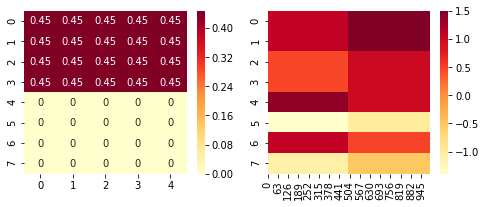

In [19]:
Mus = GenFVecs(nR, eigIndAll[:nR], ChgsFreqF)
Nus = GenFVecs(nR, eigIndAll[:nR], ChgsTF)
idx1 = ChgsFreqF[1]
Mus[:, 0:idx1].imag = 0
stdMus =  Mus /np.linalg.norm(Mus, axis=1).reshape(-1, 1)
Nus =  3*Nus /np.linalg.norm(Nus, axis=0).reshape(1, -1) # to make the ts stationary

tMus = np.concatenate([stdMus.real, stdMus.imag])
tNus = np.concatenate([Nus.real, Nus.imag])
plt.figure(figsize=[8, 3])
plt.subplot(121)
sns.heatmap(tMus,  cmap="YlOrRd", annot=True)
plt.subplot(122)
sns.heatmap(tNus,  cmap="YlOrRd", annot=False)

In [20]:
XY = np.zeros((d, dF, dT+1))
XY[:, :, 0] = Xmat0 

#### Generate the TS

In [21]:
num = d
invU = np.linalg.inv(U)
for dt in range(dT):
    for df in range(dF):
        cX = XY[:, df, dt]
        cMu = stdMus[:, df]
        cNu = Nus[:, dt]
        pEigVs = cMu * cNu
        # pEigVs = pEigVs / np.max(np.abs(pEigVs))
        cEigVs = np.diag(np.concatenate([pEigVs, np.zeros(num - len(cMu))]))
        cA = np.matmul(np.matmul(U, cEigVs), invU)
        cAr = cA.real # theroetically, imag part should be 0
        cY = np.matmul(cAr, cX)  + 0.4*np.random.randn(d)
        XY[:, df, dt+1] = cY

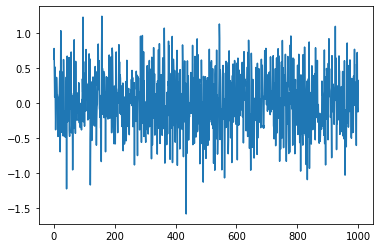

In [22]:
ts = XY[0, 0, :]
plt.plot(ts)

In [23]:
Y = XY[:, :, 1:]
X = XY[:, :, :-1]

### Algorithm

In [24]:
fs = 600
Rn = nR
Rn = 4
T = 6
bandsCuts = [[2, 3.5], [4, 7], [8, 12], [13, 30], [30, 80]]
times = np.linspace(0, T, dT)
freqs = np.array([np.mean(bandCut) for bandCut in bandsCuts])
hs = [bw_nrd0_R(freqs), bw_nrd0_R(times)]

lams = [3e1, 1e1]
downrates = [1, 1]
q = 50
iterNums = [10, 10]
iterCs = [1e-6, 1e-6]
As = [2.7, 2.7]
alps = [0.9, 0.9]
outIterC = 1e-5
betas = [50, 50]

#### Test for Amat

In [25]:
Xt = torch.tensor(X)
Yt = torch.tensor(Y)
Amat = GetAmatTorch(Yt[:, :, :], Xt[:, :, :], times, freqs, [1, 1], hs=hs)

In [28]:
res = np.linalg.eig(Amat)
eU = res[1]
einvU = np.linalg.inv(eU)
np.linalg.norm(np.sum(np.abs(einvU[:Rn, :]), axis=0) - np.sum(np.abs(invU[:Rn, :]), axis=0))

1.2340700069178416

[0 1 3 2]


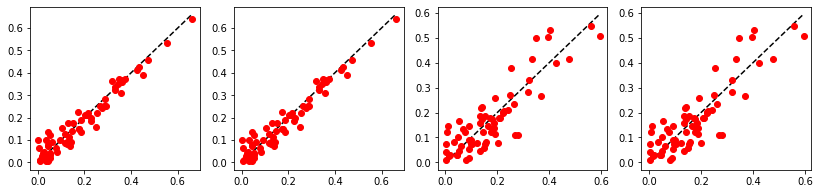

In [29]:
nrow = Rn
pU = einvU[:nrow, :]
ptU = invU[:nrow, :]
rords = matchU(pU, ptU)
# rords = np.array([0, 1, 2, 3, 4, 5])
print(rords)
rptU = ptU[rords]
fig, axs = plt.subplots(1, Rn, figsize=(3*nrow+2,3))
for i in range(nrow):
    cpU = pU[i, :].real
    cptU = rptU[i, :].real
    mv = np.max([np.abs(cpU).max(), np.abs(cptU).max()])
    xs = ys = np.linspace(0, mv, 1000)
    axs[i].plot(xs, ys, ls='--',c='k')
    axs[i].plot(np.abs(cpU), np.abs(cptU), "ro", label=f"Vector {i+1}")

#### Run 

In [39]:
fs = 600
Rn = nR
Rn = 4
T = 6
bandsCuts = [[2, 3.5], [4, 7], [8, 12], [13, 30], [30, 80]]
times = np.linspace(0, T, dT)
freqs = np.array([np.mean(bandCut) for bandCut in bandsCuts])
hs = [bw_nrd0_R(freqs), bw_nrd0_R(times)]

lams = [8e1, 1e1]
downrates = [1, 1]
q = 50
iterNums = [-1, 10]
iterCs = [1e-6, 1e-6]
As = [2.7, 2.7]
alps = [0.9, 0.9]
outIterC = 1e-5
betas = [100, 60]

In [40]:
paraMuInit = torch.tensor(tMus)
paraNuInit = torch.tensor(tNus)
paraMuInit = None
paraNuInit = None

In [41]:
fOpt = TVDNextOpt(rawDat=None, fs=fs, T=T, hs=hs, Rn=Rn, lams=lams, downrates=downrates, q=q, 
                  iterNums=iterNums, iterCs=iterCs, As=As, alps=alps,
                  outIterC=outIterC, maxIter=1000, betas=betas, 
                  paraMuInit=paraMuInit,paraNuInit=paraNuInit)
fOpt.X = torch.tensor(X)
fOpt.Y = torch.tensor(Y)

fOpt._estAmat()
fOpt.pUinv = torch.tensor(invU[np.array([0, 2]), :])

In [ ]:
fOpt(False, maxIter=100)

#### Plot the results

In [34]:
reidx = np.array([0, 2, 4, 6], dtype=np.int)
# reidx = np.array(list(range(8)), dtype=np.int)

/home/huaqingj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [35]:
eMus = fOpt.lastOptMu.GamMatStd.cpu().numpy()
eThetas = fOpt.lastOptMu.ThetaMatStd.cpu().numpy()
tMus = np.concatenate([stdMus.real, stdMus.imag])[reidx, :]
eDiffMus = np.diff(eMus)

([], <a list of 0 Text major ticklabel objects>)

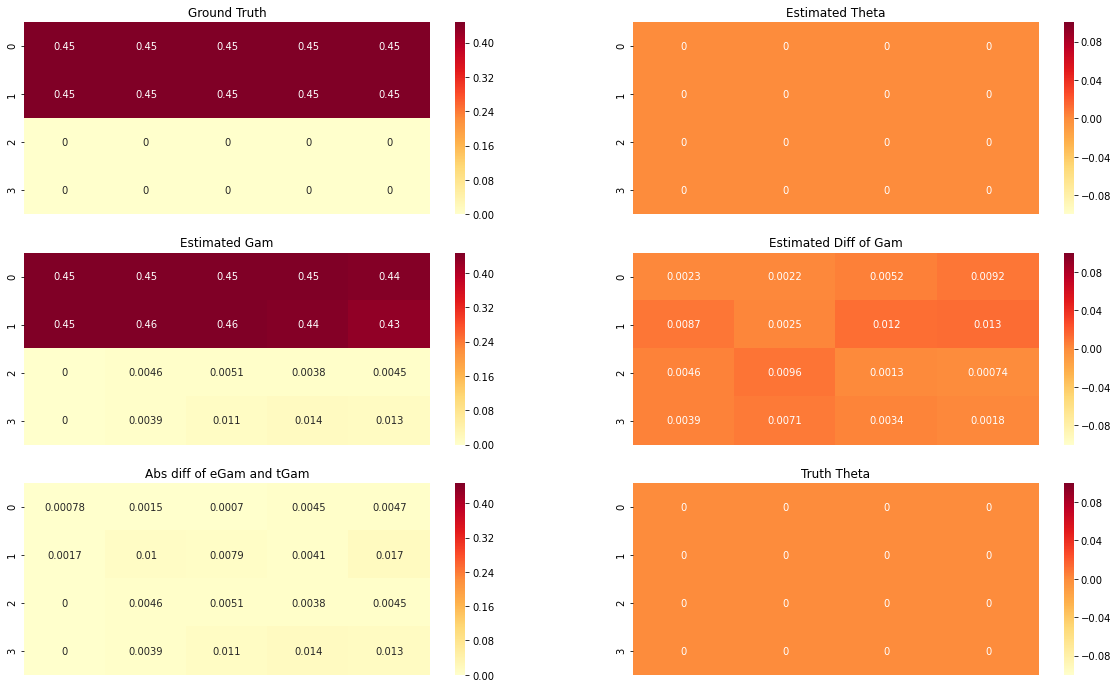

In [36]:
plt.figure(figsize=[20, 12])

vmin, vmax = np.min(np.abs(tMus)), np.max(np.abs(tMus))
is_annot = True
plt.subplot(321)
plt.title("Ground Truth")
sns.heatmap(np.abs(tMus), cmap="YlOrRd",  annot=is_annot, vmin=vmin, vmax=vmax)
plt.xticks([])

plt.subplot(323)
plt.title("Estimated Gam")
sns.heatmap(np.abs(eMus), cmap="YlOrRd",  annot=is_annot, vmin=vmin, vmax=vmax)
plt.xticks([])

plt.subplot(325)
plt.title("Abs diff of eGam and tGam")
sns.heatmap(np.abs(np.abs(tMus)-np.abs(eMus)), cmap="YlOrRd",  annot=is_annot, vmin=vmin, vmax=vmax)
plt.xticks([])

vmin, vmax = np.min(np.abs(np.diff(tMus))), np.max(np.abs(np.diff(tMus)))

plt.subplot(322)
plt.title("Estimated Theta")
sns.heatmap(np.abs(eThetas), cmap="YlOrRd",  annot=is_annot, vmin=vmin, vmax=vmax)
plt.xticks([])

plt.subplot(324)
plt.title("Estimated Diff of Gam")
sns.heatmap(np.abs(eDiffMus), cmap="YlOrRd",  annot=is_annot, vmin=vmin, vmax=vmax)
plt.xticks([])

plt.subplot(326)
plt.title("Truth Theta")
sns.heatmap(np.abs(np.diff(tMus)), cmap="YlOrRd",  annot=is_annot, vmin=vmin, vmax=vmax)
plt.xticks([])

In [37]:
eNus = fOpt.lastOptNu.GamMat.cpu().numpy()
eThetas = fOpt.lastOptNu.ThetaMat.cpu().numpy()
tNus = np.concatenate([Nus.real, Nus.imag])[reidx, :]
eDiffNus = np.diff(eNus)

([], <a list of 0 Text major ticklabel objects>)

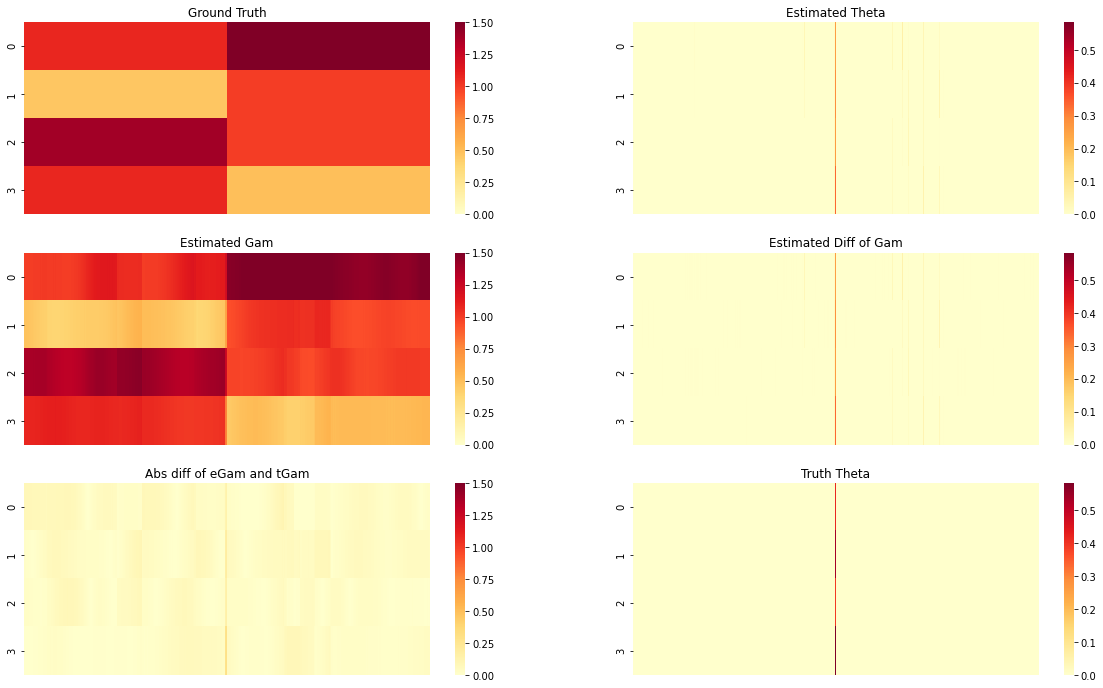

In [38]:
plt.figure(figsize=[20, 12])

vmin, vmax = 0, np.max(np.abs(tNus))
is_annot = False
plt.subplot(321)
plt.title("Ground Truth")
sns.heatmap(np.abs(tNus), cmap="YlOrRd",  annot=is_annot, vmin=vmin, vmax=vmax)
plt.xticks([])

plt.subplot(323)
plt.title("Estimated Gam")
sns.heatmap(np.abs(eNus), cmap="YlOrRd",  annot=is_annot, vmin=vmin, vmax=vmax)
plt.xticks([])

plt.subplot(325)
plt.title("Abs diff of eGam and tGam")
sns.heatmap(np.abs(np.abs(tNus)-np.abs(eNus)), cmap="YlOrRd",  annot=is_annot, vmin=vmin, vmax=vmax)
plt.xticks([])

vmin, vmax = np.min(np.abs(np.diff(tNus))), np.max(np.abs(np.diff(tNus)))

plt.subplot(322)
plt.title("Estimated Theta")
#sns.heatmap(np.abs(eThetas), cmap="YlOrRd",  annot=is_annot)
sns.heatmap(np.abs(eThetas), cmap="YlOrRd",  annot=is_annot, vmin=vmin, vmax=vmax)
plt.xticks([])

plt.subplot(324)
plt.title("Estimated Diff of Gam")
#sns.heatmap(np.abs(eDiffNus), cmap="YlOrRd",  annot=is_annot)
sns.heatmap(np.abs(eDiffNus), cmap="YlOrRd",  annot=is_annot, vmin=vmin, vmax=vmax)
plt.xticks([])

plt.subplot(326)
plt.title("Truth Theta")
#sns.heatmap(np.abs(np.diff(tNus))[:, :], cmap="YlOrRd",  annot=is_annot)
sns.heatmap(np.abs(np.diff(tNus))[:, :], cmap="YlOrRd",  annot=is_annot, vmin=vmin, vmax=vmax)
plt.xticks([])